In [ ]:
!pip install kaggle

# Assuming you have your kaggle.json file uploaded to your Colab environment
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

!unzip coronahack-chest-xraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image


In [ ]:

extracted_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
label_info_path = "Chest_xray_Corona_Metadata.csv"

# Check if the file exists at the given path
if os.path.exists(label_info_path):
    df = pd.read_csv(label_info_path)
    df.head()
else:
    print(f"Error: File not found at {label_info_path}")
    print("Please check if the dataset was correctly unzipped.")
    print("The unzipped folder should contain 'Chest_xray_Corona_Metadata.csv'")

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
X_ray_image_name,0
Label,0
Dataset_type,0
Label_2_Virus_category,5841
Label_1_Virus_category,1576


In [ ]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [ ]:
path_metadata = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv'
path_train = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
path_test = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
path_fasttext = '../input/fasttext-common-crawl-bin-model/cc.en.300.bin'
path_test_img = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/kjr-21-e24-g003-l-a.jpg'

In [ ]:
df1 = df.copy()
df1.Label_1_Virus_category.fillna(df1.Label, inplace=True)
df1.Label_2_Virus_category.fillna(df1.Label_1_Virus_category,
                                          inplace=True)
df1.drop(['Label', 'Label_1_Virus_category'], axis=1, inplace=True)
df1.rename(columns={'X_ray_image_name':  'Filename',
                            'Dataset_type': 'Type',
                            'Label_2_Virus_category': 'Class'}, inplace=True)
df1.Class.replace({'Virus': 'viral pneumonia',
                           'bacteria': 'bacterial pneumonia',
                           'Normal': 'normal',
                           'COVID-19': 'covid-19'}, inplace=True)
df1

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal
...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,TEST,viral pneumonia
5906,5929,person1635_virus_2831.jpeg,TEST,viral pneumonia
5907,5930,person1634_virus_2830.jpeg,TEST,viral pneumonia
5908,5931,person1633_virus_2829.jpeg,TEST,viral pneumonia


In [ ]:
df1.shape

(5910, 4)

In [ ]:
df1['Class'].value_counts()

,count
Class,
bacterial pneumonia,2772
normal,1576
viral pneumonia,1493
covid-19,58
Streptococcus,5
SARS,4
ARDS,2


In [ ]:
# dataframes (training, validation, testing)
df_train = df1[(df1.Type == 'TRAIN')]
df_test = df1[(df1.Type == 'TEST').reset_index(drop=True)]
# df_zsl = df[(df.Class.isin(class_zsl))].reset_index(drop=True)

In [ ]:
df_train.head()

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal


In [ ]:
df_train.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Type','Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_train.head()

,Filename,Class
0,IM-0128-0001.jpeg,normal
1,IM-0127-0001.jpeg,normal
2,IM-0125-0001.jpeg,normal
3,IM-0122-0001.jpeg,normal
4,IM-0119-0001.jpeg,normal


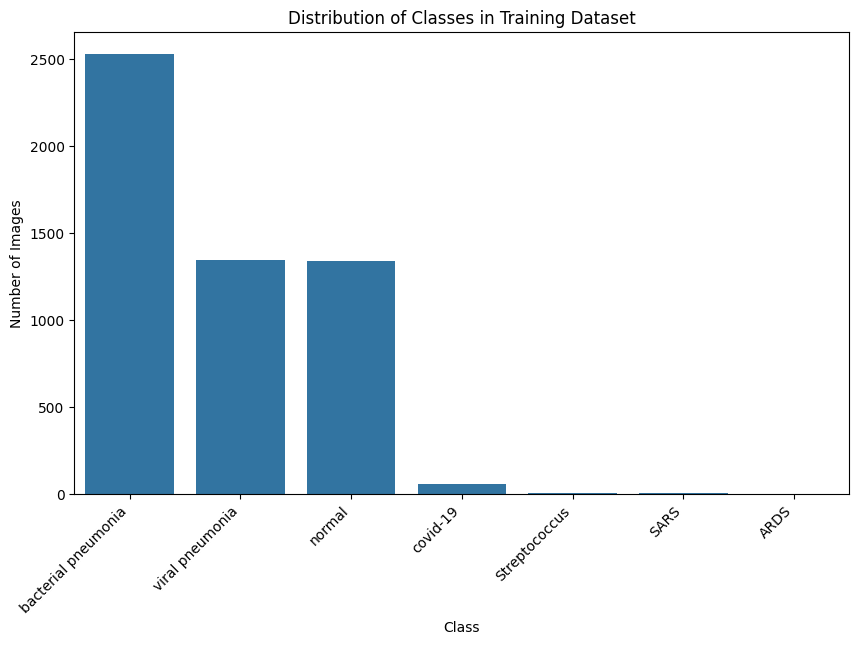

In [ ]:


# Count the occurrences of each class
class_counts = df_train['Class'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# prompt: select bacterial pneumonia,  viral pneumonia, normal from train dataset

import pandas as pd

# Assuming df_train is already defined from the previous code
selected_classes = ['bacterial pneumonia', 'viral pneumonia', 'normal']
df_train = df_train[df_train['Class'].isin(selected_classes)]

df_train

,Filename,Class
0,IM-0128-0001.jpeg,normal
1,IM-0127-0001.jpeg,normal
2,IM-0125-0001.jpeg,normal
3,IM-0122-0001.jpeg,normal
4,IM-0119-0001.jpeg,normal
...,...,...
5212,person88_virus_167.jpeg,viral pneumonia
5213,person88_virus_166.jpeg,viral pneumonia
5214,person88_virus_165.jpeg,viral pneumonia
5215,person88_virus_164.jpeg,viral pneumonia


In [ ]:
X_train = df_train['Filename']
y_train = df_train['Class']
X_test = df_test['Filename']
y_test = df_test['Class']

In [ ]:
idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2) )
idg_test = image.ImageDataGenerator(rescale=1/255)

data_train = idg_train.flow_from_dataframe(dataframe=df_train,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')
data_test = idg_test.flow_from_dataframe(dataframe=df_test,
                                          directory=path_test,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          shuffle=True,
                                          class_mode='categorical')

Found 5217 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [ ]:
data_train.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

In [ ]:
data_test.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

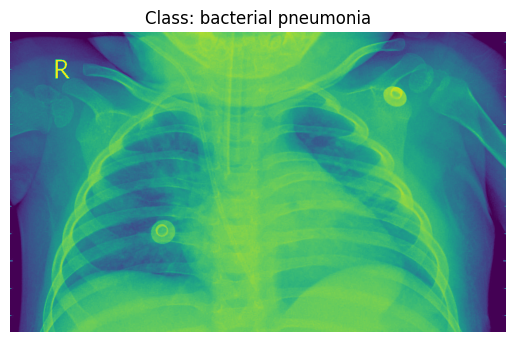

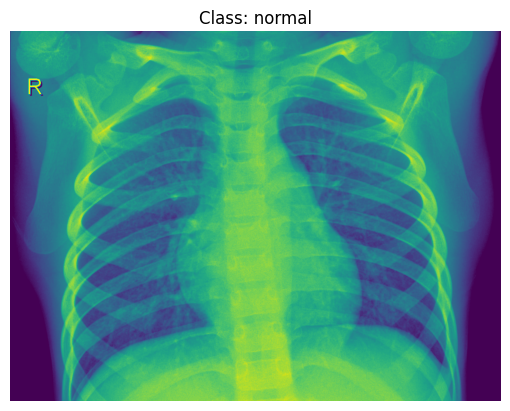

In [ ]:


import random
import matplotlib.pyplot as plt

def load_and_display_random_image(df, path):
  """Loads and displays a random image from the specified dataset."""

  # Choose a random index from the DataFrame
  random_index = random.randint(0, len(df) - 1)

  # Get the filename and class from the DataFrame
  filename = df.iloc[random_index]['Filename']
  class_label = df.iloc[random_index]['Class']

  # Construct the image path
  image_path = os.path.join(path, filename)

  # Load the image using matplotlib
  try:
      img = plt.imread(image_path)
      plt.imshow(img)
      plt.title(f"Class: {class_label}")
      plt.axis('off') # Hide axis ticks and labels
      plt.show()

  except FileNotFoundError:
      print(f"Error: Image file not found at {image_path}")

# Example usage for the training dataset:
load_and_display_random_image(df_train, path_train)

# Example usage for the testing dataset:
load_and_display_random_image(df_test, path_test)

In [ ]:
data_train.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

In [ ]:
# prompt: generate a cnn model

def create_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model.summary()

# Train the model (assuming you have 'data_train' and 'data_test' from previous code)
# history = model.fit(data_train, epochs=10, validation_data=data_test) #Example, adjust epochs as needed


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │         559,875 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,267 (2.21 MB)

 Trainable params: 579,267 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
data_train

In [ ]:
# prompt: fit the model

# Train the model (assuming you have 'data_train' and 'data_test' from previous code)
history = model.fit(data_train, epochs=10, validation_data=data_test) #Example, adjust epochs as needed

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.4935 - loss: 1.3815 - val_accuracy: 0.7885 - val_loss: 0.6077
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.6895 - loss: 0.7141 - val_accuracy: 0.7788 - val_loss: 0.6186
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.7072 - loss: 0.6498 - val_accuracy: 0.7019 - val_loss: 0.7422
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.7180 - loss: 0.6666 - val_accuracy: 0.7740 - val_loss: 0.6136
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.7248 - loss: 0.6452 - val_accuracy: 0.7420 - val_loss: 0.6694
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.7397 - loss: 0.5982 - val_accuracy: 0.7853 - val_loss: 0.6399
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.7421 - loss: 0.5925 - val_accuracy: 0.8077 - val_loss: 0.5535
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.7304 - loss: 0.6168 - val_accu

In [ ]:
# prompt: save the model

model.save('my_model.h5')

In [ ]:

# Load the saved model
model = keras.models.load_model('my_model.h5')

# To download the model file from Colab:
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(data_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 954ms/step - accuracy: 0.7715 - loss: 0.5743


[0.5453322529792786, 0.7900640964508057]

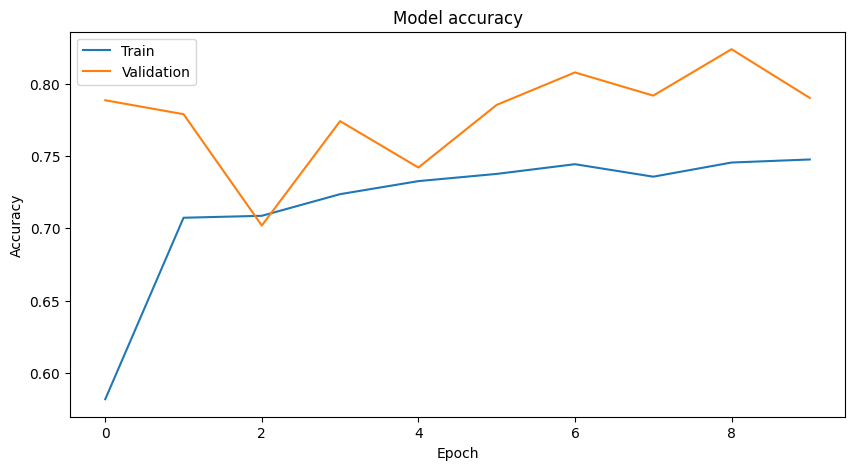

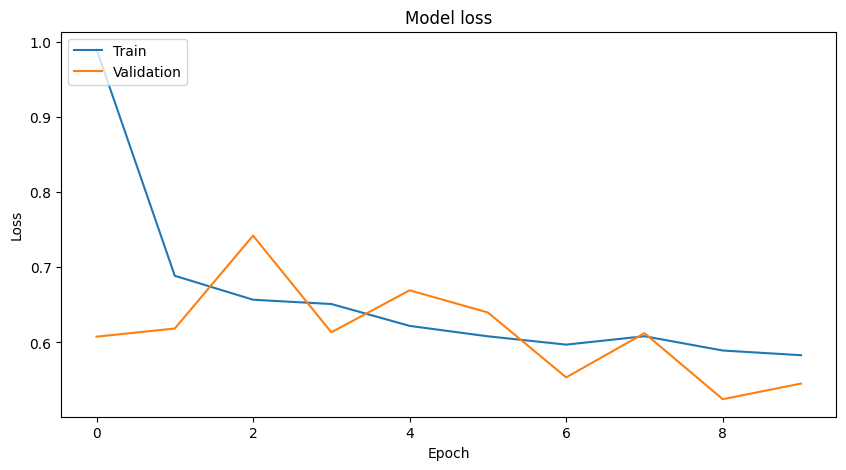

In [ ]:
# prompt: visualize accuracy and loss

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
# prompt: hyperparameter tuning for cnn model

import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(224, 224, 3)))

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(layers.Dense(3, activation='softmax'))  # Output layer

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,  # Adjust the number of trials as needed
    executions_per_trial=2, # Adjust the number of executions per trial
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(data_train, epochs=10, validation_data=data_test)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.
Optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

In [ ]:


import tensorflow as tf
from tensorflow import keras

# Load the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(data_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
predictions = best_model.predict(data_test)

# Get predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Print some example predictions
print("Example Predictions:")
for i in range(10):  # Print the first 10 predictions
    print(f"Image {i+1}: Predicted Label - {predicted_labels[i]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 587ms/step - accuracy: 0.8278 - loss: 0.5472
Test Loss: 0.5651
Test Accuracy: 0.8221
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step
Example Predictions:
Image 1: Predicted Label - 0
Image 2: Predicted Label - 0
Image 3: Predicted Label - 2
Image 4: Predicted Label - 2
Image 5: Predicted Label - 1
Image 6: Predicted Label - 0
Image 7: Predicted Label - 0
Image 8: Predicted Label - 1
Image 9: Predicted Label - 0
Image 10: Predicted Label - 2


In [ ]:


import matplotlib.pyplot as plt

# Train the best model and get its history
best_model_history = best_model.fit(data_train, epochs=10, validation_data=data_test)


# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Original Model Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Original Model Validation Accuracy')
plt.plot(best_model_history.history['accuracy'], label='Best Model Train Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Best Model Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Original Model Train Loss')
plt.plot(history.history['val_loss'], label='Original Model Validation Loss')
plt.plot(best_model_history.history['loss'], label='Best Model Train Loss')
plt.plot(best_model_history.history['val_loss'], label='Best Model Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:

# Save the best model
best_model.save('best_model.h5')

# Download the model file
files.download('best_model.h5')

# Load the saved model
loaded_best_model = keras.models.load_model('best_model.h5')



NameError: name 'files' is not defined

In [ ]:

import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Load the saved model
model = keras.models.load_model('my_model.h5')

# Load and preprocess the image
img_path = 'test.jpg'  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the image

# Make the prediction
predictions = loaded_best_model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Get the class labels (assuming you have them stored somewhere)
class_labels = list(data_train.class_indices.keys()) #Get class labels from the training data generator

# Print the prediction
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Prediction probabilities: {predictions}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'my_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)